# Ladder Simulation 2.0
## Goals
 - Create a computer simulation of the Clash Royale ladder
 - Use the simultation to determine the effects of different matchmaking rules
 - Test Card Level based matchmaking
 - Test King tower matchmaking
 - Test no matchmaking rules
 - Change the reset point and reset %
 - Change Inflation rules
        -Reset into arenas

In [1]:
import random
import player as pl
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [232]:
#Global Variables:
COLS = ["ID", "Trophies", "Wins","Losses", "King Tower", "Card Level","Total Level Difference", "LvlDiff/Match"]
PALETTE = sns.color_palette("Accent", as_cmap=True)

In [2]:
def createArray(numPlayers, trophies):
    """Creates an array of player objects
    Params:
    numPlayers: Integer, number of player objects to be created
    trophies: the starting number of trophies"""
    playerList = [pl.createPlayer(random.choice(range(8,15)), id = i, trophies= trophies) for  i in range(numPlayers)]
    return np.asarray(playerList)

In [3]:
def simulate(numPlayers, initialTrophies, numMatches):
    """Simulates the CR ladder with numPlayers players starting at initialTrophies
    Used to set a baseline for uniform distributino of players across KTs
    plays numMatches matches
    Args:  numPlayers - int, number of players in the ladder
    initialTrophies - int, initial starting numbr of trophies
    numMatches - int, Number of matches to play
    """
    playerArr = createArray(numPlayers, initialTrophies)
    queue = np.asarray([random.choice(playerArr)], dtype = object)
    matchesPlayed = 0
    maxQueueSize = 0
    while matchesPlayed < numMatches:
        if matchesPlayed %(numMatches//10) == 0:
            print(matchesPlayed)
        if queue.size> maxQueueSize:
            maxQueueSize = queue.size
        if queue.size == 0:
            queue = np.append(queue, random.choice(playerArr))
            pass
        else:
            newPlayer = random.choice(playerArr)
            addPos = np.searchsorted(queue, newPlayer)
            if newPlayer in queue:
                pass #can't play against themself
            else:
                addPos = np.searchsorted(queue, newPlayer)
                try:
                    opponent = queue[addPos]
                except IndexError as error:
                    queue = np.insert(queue, addPos, newPlayer)
                    pass
                if opponent.matchAllowed(newPlayer):
                    newPlayer.playMatch(opponent)
                    matchesPlayed += 1
                    queue = np.delete(queue, addPos)
                else:
                    queue = np.insert(queue, addPos, newPlayer)
    playerArr.sort()
    print(f"Max queue size: {maxQueueSize}")
    return playerArr

In [333]:
def continueSim(playerArr, numMatches, mode = None, cardLvlRule = 0, KTdiff = 0, KTcutoff = 5000):
    """Continues a simulation for numMatches more games
    Args: 
    playerArr: Array of player objects.  
    numMatches: Number of matches to be played
    mode: The type of matchmaking to use.  Either 'KT', 'CL', 'KTCL'
    cardLvlRule: Int, the maximum difference in card levels allowed in a match
    KTdiff: The maximum difference in king tower between both players
    KTcutoff: The maximum trophies where the KT diff rule applies. """
    queue = np.asarray([random.choice(playerArr)], dtype = object)
    matchesPlayed = 0
    cardRule = lambda p1, p2: abs(p1.cardLevel - p2.cardLevel) < cardLvlRule
    kTDiffRule = lambda p1, p2: abs(p1.kt - p2.kt) < KTdiff
    ktCutoffRule = lambda p: p.trophies > KTcutoff
    maxQueueSize = 0
    numMatches += 10 #off sets the matches played counter
    while matchesPlayed < numMatches:

        if matchesPlayed %(numMatches//10) == 0:
            print(matchesPlayed)
            matchesPlayed += 1 #just to prevent spam
        if queue.size == 0:
            queue = np.append(queue, random.choice(playerArr))
            pass
        if queue.size> maxQueueSize:
            maxQueueSize = queue.size
            
        else:
            newPlayer = random.choice(playerArr)
            addPos = np.searchsorted(queue, newPlayer)
            if newPlayer in queue:
                pass #can't play against themself
            else:
                addPos = np.searchsorted(queue, newPlayer)
                try:
                    opponent = queue[addPos]
                except IndexError as error:
                    queue = np.insert(queue, addPos, newPlayer)
                    pass 
                try: 
                    if allowMatch(newPlayer, opponent, mode = mode, cardLvlRule = cardLvlRule, KTdiff = KTdiff, KTcutoff = KTcutoff):
                            newPlayer.playMatch(opponent)
                            matchesPlayed += 1
                            queue = np.delete(queue, addPos)
                    else:
                             queue = np.insert(queue, addPos, newPlayer)  
                except UnboundLocalError as error:
                    print("Rare error")
    playerArr.sort()
    return playerArr

In [334]:
def allowMatch(p1, p2, mode = None, cardLvlRule = 0, KTdiff = 0, KTcutoff = 5000):
    cardRule = lambda p1, p2: abs(p1.cardLevel - p2.cardLevel) < cardLvlRule
    KTDiffRule = lambda p1, p2: abs(p1.kt - p2.kt) <= KTdiff
    KtCutoffRule = lambda p: p.trophies > KTcutoff
    if p1.matchAllowed(p2) == False:
        return False
    elif mode == 'CL':
        return cardRule(p1, p2)
    elif mode == 'KT':
        return KTDiffRule(p1, p2) or p1.trophies > KTcutoff 
    elif mode == 'KTCL':
        return (KTDiffRule(p1, p) or p1.trophies > KTcutoff) and cardRule(p1, p2)
    else:
        return True
        

In [319]:
def plots(data):
    """Makes n plots from the data:
    Bar graph of Lvl diff/Match vs King Tower
    Histogram of Trophies and King Tower
    
    """
    df = arrToDF(data)
    df2 = arrToDF(sepByCards(data))
    plt.figure(figsize = (6, 6))
    sns.barplot(x = "King Tower", y = "LvlDiff/Match", data = df)
    
    plt.figure(figsize = (20,6))
    sns.barplot(x = "Card Level", y = "LvlDiff/Match", data = df)
    plt.xticks(rotation = -45)
    
    plt.figure(figsize = (20, 8))
    sns.histplot(data = df,
            x = 'Trophies', 
            hue = 'King Tower',
            stat = 'count',
             palette = PALETTE,
             multiple = 'stack')
    plt.figure(figsize = (20, 8))
    sns.histplot(data=df2, 
             x = 'Trophies',
             hue = 'Card Level',
             stat = 'count',
             palette = sns.color_palette("CMRmap_r", n_colors = 13),
             multiple = 'stack')
    
    plt.figure(figsize = (16, 8))    
    sns.relplot(data = df, x = "Trophies", y = "Card Level", hue = "King Tower", palette = PALETTE)
    
    plt.figure(figsize = (20, 8))
    sns.relplot(data = df, x='Trophies', y = 'LvlDiff/Match', hue = 'King Tower', palette = PALETTE)

In [323]:
def sepByCards(arr):
    """Separates an array of player objecs by cards
    """
    playerCopy = []
    for p in arr:
            new = pl.Player(id = p.id,
                            trophies=p.trophies,
                            wins=p.wins,
                            losses=p.losses,
                            kingLevel=p.kt,
                            cardLevel=p.cardLevel, 
                            totalLvlDiff=p.totalLvlDiff)
            playerCopy += [new]
    newArr = np.asarray(playerCopy)
    for player in newArr:
        if 60 <= player.cardLevel <= 63:
            player.cardLevel = '60-63'
        elif 64 <= player.cardLevel <= 67:
            player.cardLevel = '64-67'
        elif 68 <= player.cardLevel <= 71:
            player.cardLevel = '68-71'
        elif 72 <= player.cardLevel <= 75:
            player.cardLevel = '72-75'
        elif 76 <= player.cardLevel <= 79:
            player.cardLevel = '76-79'
        elif 80 <= player.cardLevel <= 83:
            player.cardLevel = '80-83'
        elif 84 <= player.cardLevel <= 87:
            player.cardLevel = '84-87'
        elif 88 <= player.cardLevel <= 91:
            player.cardLevel = '88-91'
        elif 92 <= player.cardLevel <= 95:
            player.cardLevel = '92-95'
        elif 96 <= player.cardLevel <= 99:
            player.cardLevel = '96-99'
        elif 100 <= player.cardLevel <= 103:
            player.cardLevel = '100-103'
        elif 104 <= player.cardLevel <= 107:
            player.cardLevel = '104-107'
        elif 108 <= player.cardLevel:
            player.cardLevel = '108-112'
    return newArr

In [ ]:
newArr = dfToArr(df, reset = True)
currentLadder = continueSim(newArr, 4000000, mode = 'KT', KTdiff = 1, KTcutoff = 6000)

0
400001
800002
1200003
1600004
2000005
2400006
2800007


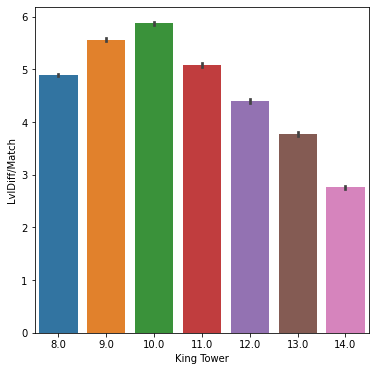

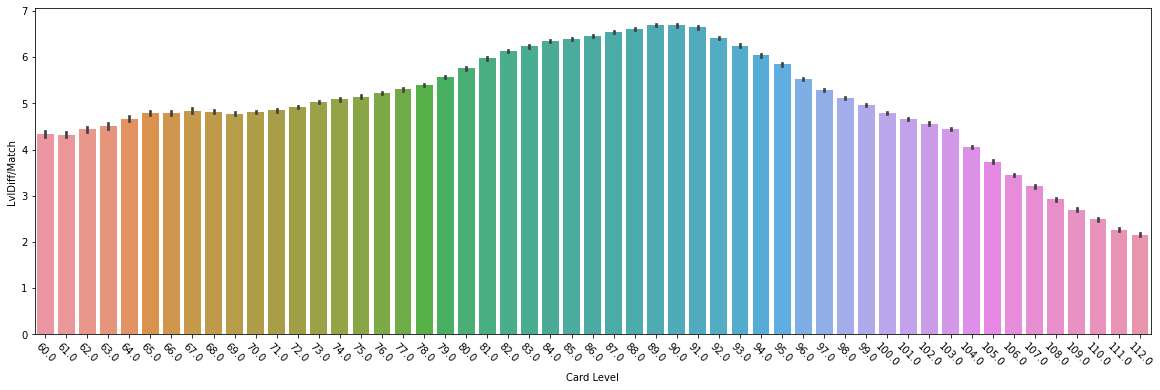

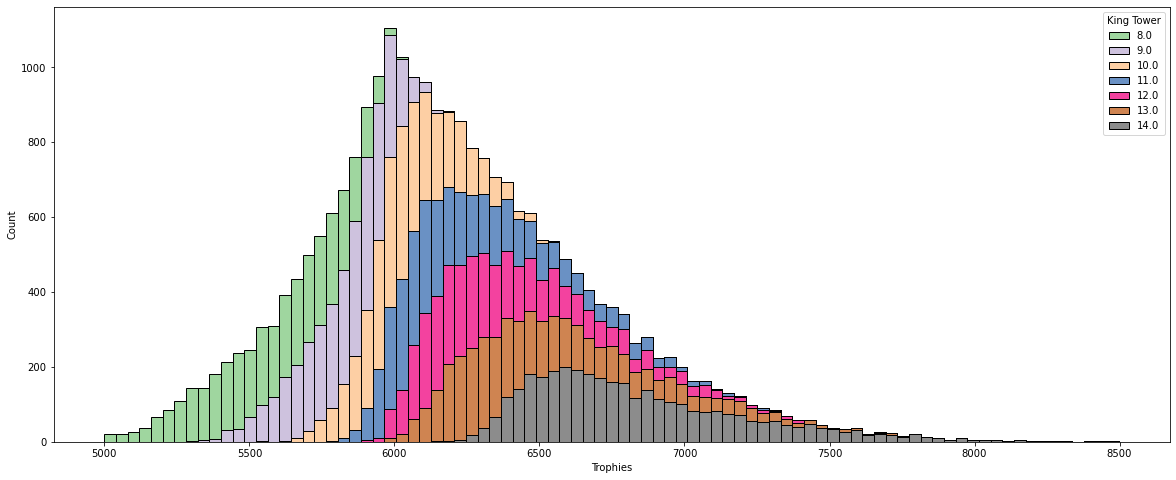

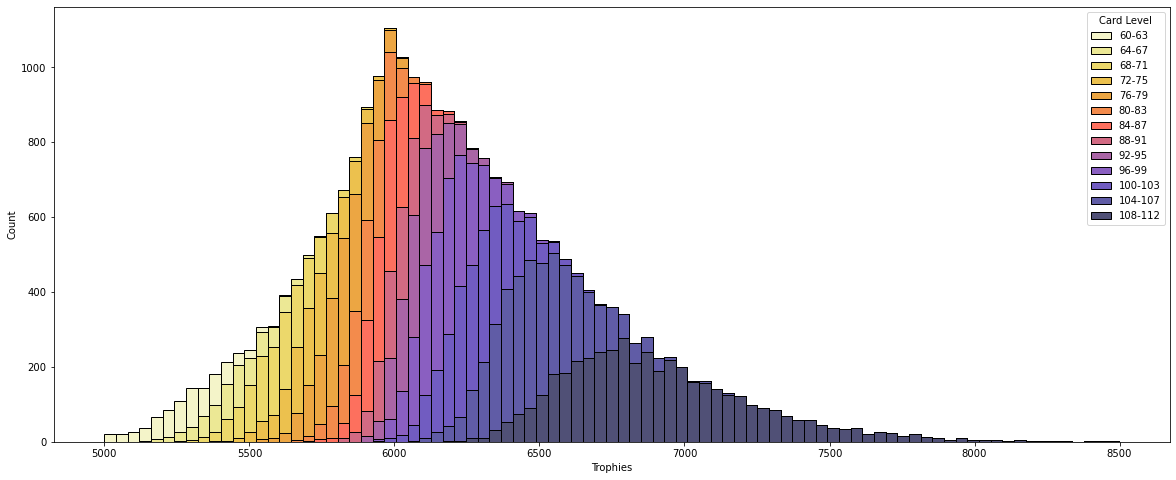

<Figure size 1152x576 with 0 Axes>

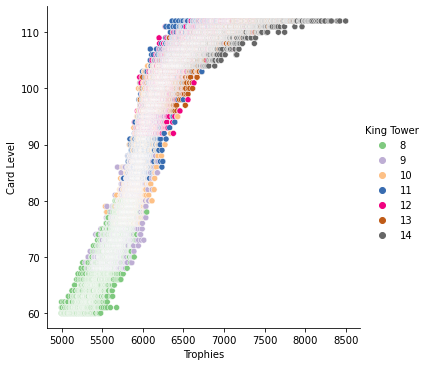

<Figure size 1440x576 with 0 Axes>

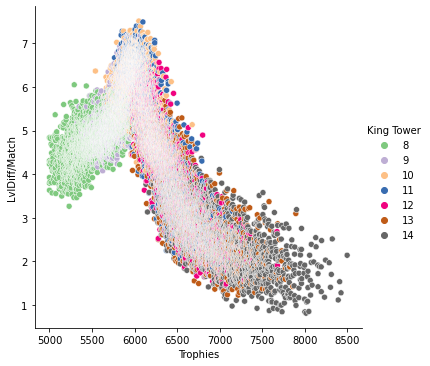

In [320]:
plots(data)

In [179]:
def arrToDF(arr):
    """Converts an array of player objects to a dataframe
    Args: arr- Array of Player objects
    Returns: dataframe. 
    """
    dataInLists = [p.getData() + [(p.totalLvlDiff/(p.wins+p.losses))] for p in arr]
    return pd.DataFrame(data = dataInLists, columns = COLS)
     
def storeDF(df, filename):
    """Stores the dataframe in csv file filename
    Args:
    df-  Dataframe to store
    filename: string, name of file"""
    df.to_csv(filename, index_label = False)
    
def dfToArr(df, reset = False):
    """Converts a dataframe back into a numpy array of player objects"""
    arrays = df.to_numpy()
    playerList = []
    if reset:
        for p in arrays:
            new = pl.Player(id = p[0], trophies = p[1],wins=0,losses =0, kingLevel=p[4],cardLevel = p[5],totalLvlDiff=p[6])
            new.reset()
            playerList += [new]
    else:
        for p in arrays:
            new = pl.Player(id = p[0],trophies=p[1],wins=p[2],losses=p[3],kingLevel=p[4],cardLevel=p[5], totalLvlDiff=p[6])
            playerList += [new]
    return np.asarray(playerList)
    

In [193]:
df = arrToDF(data)

In [227]:
df.head()

,ID,Trophies,Wins,Losses,King Tower,Card Level,Total Level Difference,LvlDiff/Match
0,8473,5000,315,474,8,60,3400,4.309252
1,13202,5000,342,476,8,62,3461,4.231051
2,8242,5000,284,460,8,60,2920,3.924731
3,15939,5000,306,440,8,60,2708,3.630027
4,18900,5000,302,496,8,60,3026,3.791980


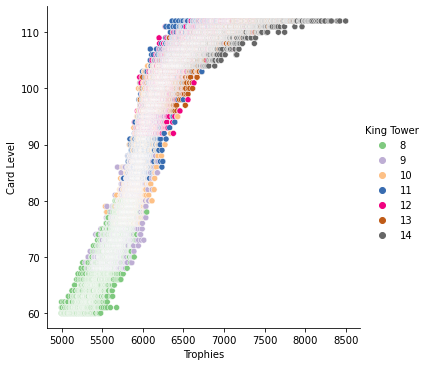

In [233]:

sns.relplot(data = df, x = "Trophies", y = "Card Level", hue = "King Tower", palette = PALETTE)


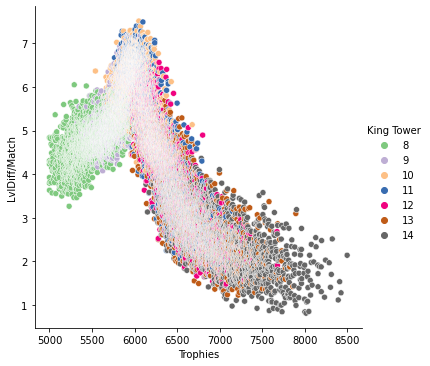

In [235]:
sns.relplot(data = df, x='Trophies', y = 'LvlDiff/Match', hue = 'King Tower', palette = PALETTE)

ValueError: Could not interpret input 'cardLevel'

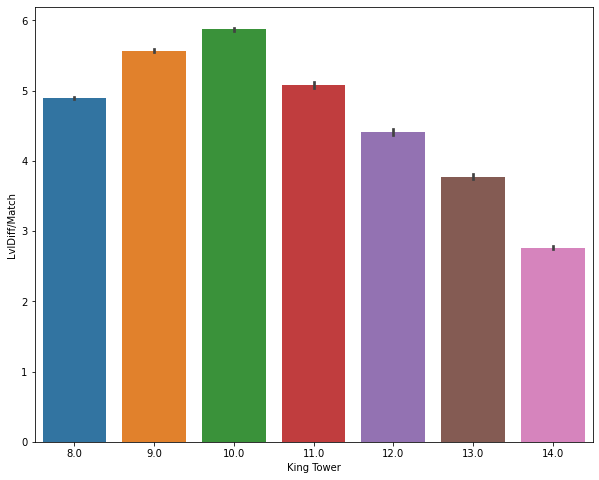

<Figure size 1440x432 with 0 Axes>

In [315]:
plots(data)

In [290]:
df2

,ID,Trophies,Wins,Losses,King Tower,Card Level,Total Level Difference,LvlDiff/Match
0,8473.0,5000.0,315.0,474.0,8.0,60-63,3400.0,4.309252
1,13202.0,5000.0,342.0,476.0,8.0,60-63,3461.0,4.231051
2,8242.0,5000.0,284.0,460.0,8.0,60-63,2920.0,3.924731
3,15939.0,5000.0,306.0,440.0,8.0,60-63,2708.0,3.630027
4,18900.0,5000.0,302.0,496.0,8.0,60-63,3026.0,3.791980
...,...,...,...,...,...,...,...,...
24995,11175.0,8323.0,403.0,307.0,14.0,108-112,1785.0,2.514085
24996,3166.0,8393.0,447.0,339.0,14.0,108-112,876.0,1.114504
24997,10044.0,8410.0,380.0,272.0,14.0,108-112,1000.0,1.533742
24998,1124.0,8426.0,406.0,297.0,14.0,108-112,899.0,1.278805


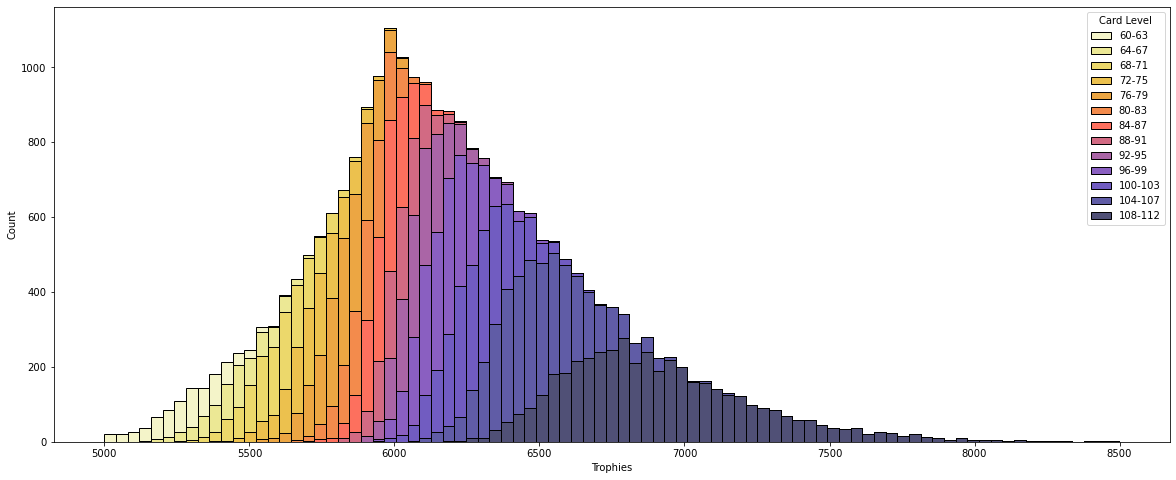

In [303]:
#Other graphs.  Number of players by trophies
#number of 
plt.figure(figsize = (20, 8))
sns.histplot(data=df2, 
             x = 'Trophies',
             hue = 'Card Level',
             stat = 'count',
             palette = sns.color_palette("CMRmap_r", n_colors = 13),
             multiple = 'stack')

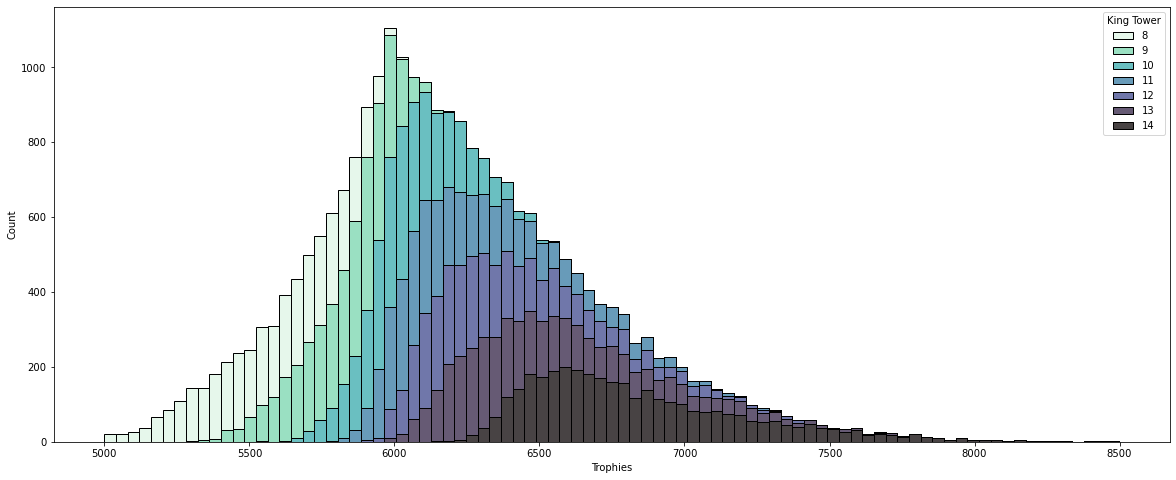

In [311]:
plt.figure(figsize = (20, 8))
sns.histplot(data = df,
            x = 'Trophies', 
            hue = 'King Tower',
            stat = 'count',
             palette = sns.color_palette("mako_r",  as_cmap=True),
             multiple = 'stack')

In [23]:
def avgLvlDiff(player):
    return player.totalLvlDiff/(player.wins+player.losses)

In [57]:
bigData = pd.read_csv('LSFAST1')

In [58]:
bigData["LvlDiff/Match"] = bigData["Card Level"]/(bigData["Wins"]+ bigData["Losses"])

In [59]:
bigData

,ID,Trophies,Wins,Losses,King Tower,Card Level,Total Level Differnce,LvlDiff/Match
0,2858,5000,330,498,8,3811,60,4.602657
1,16723,5000,304,473,8,3184,60,4.097812
2,6821,5000,278,451,8,3012,60,4.131687
3,21734,5000,322,508,8,3507,60,4.225301
4,21549,5000,319,467,8,3206,60,4.078880
...,...,...,...,...,...,...,...,...
24995,18781,8352,403,293,14,779,112,1.119253
24996,14181,8361,386,280,14,849,112,1.274775
24997,1650,8428,422,315,14,1290,112,1.750339
24998,3194,8438,414,306,14,1496,112,2.077778


In [61]:
df2 = pd.DataFrame(arr[:25], columns = cols)

In [75]:
dataFrames =[pd.DataFrame(bigData = x, columns = cols)for x in LC]

In [76]:
dataFrames[1]

,ID,Trophies,Wins,Losses,King Tower,Total Level Difference,Card Level
0,15343,5307,355,431,9,3715,68
1,15604,5320,356,415,9,3686,69
2,16043,5331,350,412,9,3614,68
3,5179,5346,362,435,9,3994,68
4,12519,5349,379,430,9,4119,73
...,...,...,...,...,...,...,...
3552,14839,6155,378,389,9,4715,87
3553,17597,6158,407,417,9,5455,87
3554,6898,6159,383,392,9,5048,86
3555,5833,6174,426,440,9,5999,85


In [136]:
#df = arrToDF(bigData)
#data = bigData.to_numpy()
#print(bigData)
#df.to_csv('LSFAST1', index_label = False)
data = dfToArr(bigData)
#cols = ["ID", "Trophies", "Wins","Losses", "King Tower", "Card Level", "Total Level Difference"]
L14 = [p.getData() for p in data if p.kt == 14]
df14 = pd.DataFrame(data = [p.getData() for p in data if p.kt == 14], columns = COLS)
df13 = pd.DataFrame(data = [p.getData() for p in data if p.kt == 13], columns = COLS)
df12 = pd.DataFrame(data = [p.getData() for p in data if p.kt == 12], columns = COLS)
df11 = pd.DataFrame(data = [p.getData() for p in data if p.kt == 11], columns = COLS)
df10 = pd.DataFrame(data = [p.getData() for p in data if p.kt == 10], columns = COLS)
df9 = pd.DataFrame(data = [p.getData() for p in data if p.kt == 9], columns = COLS)
df8 = pd.DataFrame(data = [p.getData() for p in data if p.kt == 8], columns = COLS)
L = []
for KingTower in KT
L = [pd.DataFrame(data = list(filter(lambda p: p.kt == KingTower, data))) for KingTower in [8,9,10,11,12,13,14]]

In [174]:
bigData

,ID,Trophies,Wins,Losses,King Tower,Card Level,Total Level Differnce,LvlDiff/Match,Total Level Difference
0,2858,5000,330,498,8,60,3811.0,4.602657,3811.0
1,16723,5000,304,473,8,60,3184.0,4.097812,3184.0
2,6821,5000,278,451,8,60,3012.0,4.131687,3012.0
3,21734,5000,322,508,8,60,3507.0,4.225301,3507.0
4,21549,5000,319,467,8,60,3206.0,4.078880,3206.0
...,...,...,...,...,...,...,...,...,...
24995,18781,8352,403,293,14,112,779.0,1.119253,779.0
24996,14181,8361,386,280,14,112,849.0,1.274775,849.0
24997,1650,8428,422,315,14,112,1290.0,1.750339,1290.0
24998,3194,8438,414,306,14,112,1496.0,2.077778,1496.0


In [169]:
bigData["Total Level Differnce"] = round(bigData["LvlDiff/Match"]*(bigData["Wins"] + bigData["Losses"]))

In [167]:
bigData = bigData.drop(bigData["Total Level Differnce"])

             

In [173]:
bigData.drop(bigData["Total Level Difference"])

,ID,Trophies,Wins,Losses,King Tower,Card Level,Total Level Differnce,LvlDiff/Match,Total Level Difference
0,2858,5000,330,498,8,60,3811.0,4.602657,3811.0
1,16723,5000,304,473,8,60,3184.0,4.097812,3184.0
2,6821,5000,278,451,8,60,3012.0,4.131687,3012.0
3,21734,5000,322,508,8,60,3507.0,4.225301,3507.0
4,21549,5000,319,467,8,60,3206.0,4.078880,3206.0
...,...,...,...,...,...,...,...,...,...
24995,18781,8352,403,293,14,112,779.0,1.119253,779.0
24996,14181,8361,386,280,14,112,849.0,1.274775,849.0
24997,1650,8428,422,315,14,112,1290.0,1.750339,1290.0
24998,3194,8438,414,306,14,112,1496.0,2.077778,1496.0


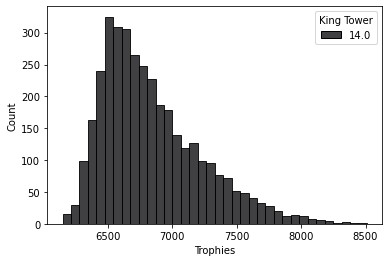

In [133]:
sns.histplot(data = df14, x = 'Trophies', 
             hue = 'King Tower',
             stat = 'count',
             palette = sns.color_palette("inferno", as_cmap=True),
             multiple = 'dodge') 

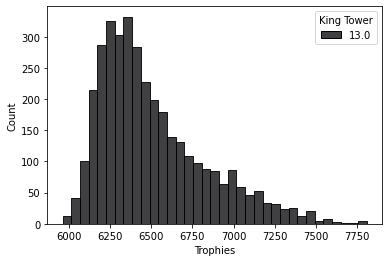

In [134]:
sns.histplot(data = df13, x = 'Trophies', 
             hue = 'King Tower',
             stat = 'count',
             palette = sns.color_palette("inferno", as_cmap=True),
             multiple = 'dodge') 


In [27]:
sns.histplot(data = df12, x = 'Trophies', 
             hue = 'King Tower',
             stat = 'count',
             palette = sns.color_palette("inferno", as_cmap=True),
             multiple = 'dodge') 


NameError: name 'df12' is not defined

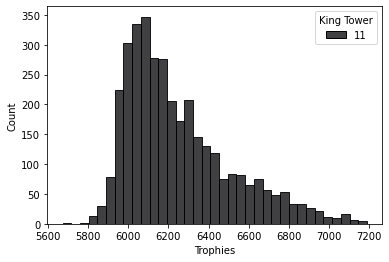

In [36]:
sns.histplot(data = df11, x = 'Trophies', 
             hue = 'King Tower',
             stat = 'count',
             palette = sns.color_palette("inferno", as_cmap=True),
             multiple = 'dodge') 


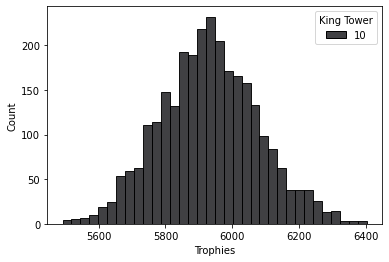

In [85]:
sns.histplot(data = df10, x = 'Trophies', 
             hue = 'King Tower',
             stat = 'count',
             palette = sns.color_palette("inferno", as_cmap=True),
             multiple ='dodge') 


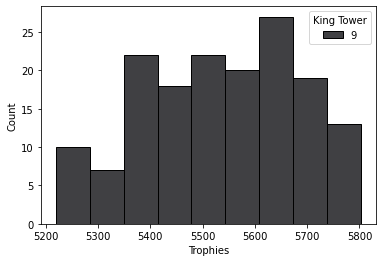

In [67]:
sns.histplot(data = df9, x = 'Trophies', 
             hue = 'King Tower',
             stat = 'count',
             palette = sns.color_palette("inferno", as_cmap=True),
             multiple = 'dodge') 

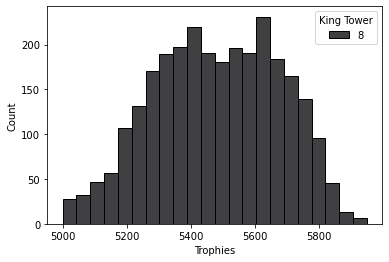

In [84]:
sns.histplot(data = df8, x = 'Trophies', 
             hue = 'King Tower',
             stat = 'count',
             palette = sns.color_palette("inferno", as_cmap=True),
             multiple = 'dodge') 
             


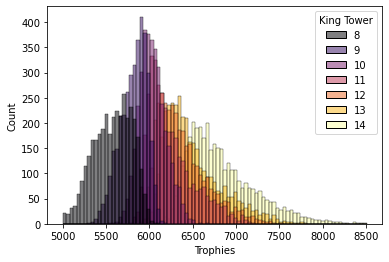

In [37]:
sns.histplot(data = df, x = 'Trophies', 
             hue = 'King Tower',
             stat = 'count',
             palette = sns.color_palette("inferno", as_cmap=True),
             multiple = 'layer') 
             


In [39]:
type(data)

numpy.ndarray